<a href="https://colab.research.google.com/github/RANVEER0117-A/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing sentiments about movie reviews using nlp

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow import keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Embedding, Bidirectional, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.utils import shuffle, resample

# Loading the file

In [ ]:
train=pd.read_csv("/content/train.tsv.zip", sep="	")
test=pd.read_csv("/content/train.tsv.zip", sep="	")
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
#Shapes
train.shape, test.shape

((156060, 4), (156060, 4))

In [ ]:
#dtypes
train.dtypes

PhraseId       int64
SentenceId     int64
Phrase        object
Sentiment      int64
dtype: object

# (Exploratory data analysis)EDA Analysis


In [ ]:
labels=train.Sentiment

<BarContainer object of 5 artists>

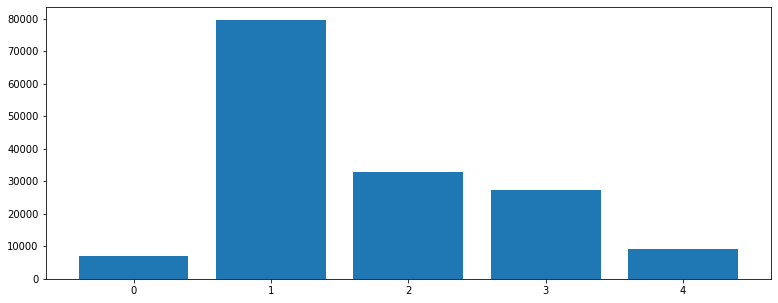

In [ ]:
plt.figure(figsize=(13,5))
plt.bar(height=train.Sentiment.value_counts(), x=train.Sentiment.unique())


# Preprocessing the data

In [ ]:
#Get the Phrase into a list, for easy text cleanup and manipulation
raw_phrases = train.Phrase.values
raw_phrases[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [ ]:
#Using regular expressions, remove IP addresses and URLs
phrases_ip_remove = [re.sub(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', text) for text in raw_phrases]
phrases_ip_remove[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [ ]:
#Using regular expressions, remove special characters
phrases_spl_remove = [re.sub('[^A-Za-z \']+', '', text) for text in phrases_ip_remove]
phrases_spl_remove[0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander  some of which occasionally amuses but none of which amounts to much of a story '

In [ ]:
#Normalize the casing
phrases_lower=[text.lower() for text in phrases_spl_remove]
phrases_lower[0]

'a series of escapades demonstrating the adage that what is good for the goose is also good for the gander  some of which occasionally amuses but none of which amounts to much of a story '

In [ ]:
#Tokenize using word_tokenize from NLTK
phrases_word_tok0=[word_tokenize(text) for text in phrases_lower]
phrases_word_tok0[0]

['a',
 'series',
 'of',
 'escapades',
 'demonstrating',
 'the',
 'adage',
 'that',
 'what',
 'is',
 'good',
 'for',
 'the',
 'goose',
 'is',
 'also',
 'good',
 'for',
 'the',
 'gander',
 'some',
 'of',
 'which',
 'occasionally',
 'amuses',
 'but',
 'none',
 'of',
 'which',
 'amounts',
 'to',
 'much',
 'of',
 'a',
 'story']

In [ ]:
#Remove punctuation single quote
phrases_word_tok=[]
for words in phrases_word_tok0:
    phrases_word_tok.append([word for word in words if word not in punctuation])
phrases_word_tok[0]

['a',
 'series',
 'of',
 'escapades',
 'demonstrating',
 'the',
 'adage',
 'that',
 'what',
 'is',
 'good',
 'for',
 'the',
 'goose',
 'is',
 'also',
 'good',
 'for',
 'the',
 'gander',
 'some',
 'of',
 'which',
 'occasionally',
 'amuses',
 'but',
 'none',
 'of',
 'which',
 'amounts',
 'to',
 'much',
 'of',
 'a',
 'story']

In [ ]:
#Flatten
cleaned_phrases_train=[]
for text in phrases_word_tok:
    cleaned_phrases_train.append(" ".join(word for word in text))
cleaned_phrases_train[0]

'a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story'

In [ ]:
#validation set
x_train, x_val, y_train, y_val = train_test_split(cleaned_phrases_train, labels, test_size=0.10, random_state=10)


In [ ]:
#Training features and labels
#Padding Sequences
labels=train.Sentiment.values
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
x_train=pad_sequences(sequences, maxlen=200)
sequences = tokenizer.texts_to_sequences(x_val)
x_val=pad_sequences(sequences, maxlen=200)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((140454, 200), (140454,), (15606, 200), (15606,))

In [ ]:
#Function for Preprocessing for test data
def Preprocess(test):
        
    #Get the Phrase into a list, for easy text cleanup and manipulation
    raw_phrases = test.Phrase.values
    
    #Using regular expressions, remove URLs
    phrases_ip_remove = [re.sub(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', text) for text in raw_phrases]
    
       
    #Using regular expressions, remove special characters
    phrases_spl_remove = [re.sub('[^A-Za-z \']+', '', text) for text in phrases_ip_remove]
    phrases_spl_remove[0]

    #Normalize the casing
    phrases_lower=[text.lower() for text in phrases_spl_remove]
    
    #Tokenize using word_tokenize from NLTK
    phrases_word_tok0=[word_tokenize(text) for text in phrases_lower]
    
    #Remove punctuation single quote
    phrases_word_tok=[]
    for words in phrases_word_tok0:
        phrases_word_tok.append([word for word in words if word not in punctuation])
    phrases_word_tok[0]
    
    
    #Flatten
    cleaned_phrases=[]
    for text in phrases_word_tok:
        cleaned_phrases.append(" ".join(word for word in text))

    #convert to sequences
    sequences = tokenizer.texts_to_sequences(cleaned_phrases)
    test_trans=pad_sequences(sequences, maxlen=200)

    return test_trans

# Model Building and Evaluation

In [ ]:
model=Sequential()
model.add(Embedding(20000, 500, input_length=x_train.shape[1])),
model.add(Bidirectional(LSTM(64,  activation='relu'))),

model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 500)          10000000  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              289280    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16)                0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, to_categorical(y_train), epochs=1, batch_size=289, validation_data=(x_val, to_categorical(y_val)))

486/486 [==============================] - 195s 391ms/step - loss: 1.2625 - accuracy: 0.5197 - val_loss: 1.0134 - val_accuracy: 0.5747


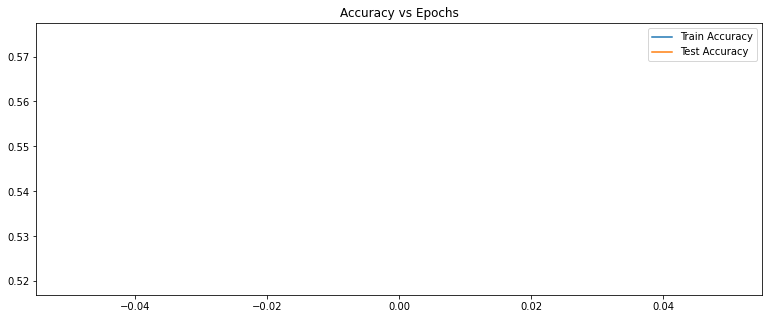

In [ ]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
model.evaluate(x_val, to_categorical(y_val))

488/488 [==============================] - 37s 76ms/step - loss: 1.0134 - accuracy: 0.5747


[1.0133782625198364, 0.5747148394584656]

In [ ]:
#Predict test data
test_data = Preprocess(test)
test['Sentiment'] = np.argmax(model.predict(test_data), axis=1)

In [ ]:
test['Sentiment'] = test['Sentiment'].map({0: 'negative', 1: 'somewhat negative', 2: 'neutral', 3: 'somewhat positive', 4: 'positive'})

In [ ]:
print(test['Sentiment'])

0         neutral
1         neutral
2         neutral
3         neutral
4         neutral
           ...   
156055    neutral
156056    neutral
156057    neutral
156058    neutral
156059    neutral
Name: Sentiment, Length: 156060, dtype: object
